# A Hybrid Framework for Person Classification in CCTV with Low Resources

Be sure to clone the repo with the <code>--recurse-submodules</code> flag

<code>!git clone --recurse-submodules https://github.com/prahtz/lr-human-detection </code>

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import os

src_path = os.path.abspath("../src")
bkg_src_path = os.path.abspath("../intrusion-detection-project/src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)
if bkg_src_path not in sys.path:
    sys.path.insert(0, bkg_src_path)

import random
from datasets.prw import PRWRawDataset, PRWClassification, PRWClassificationFromSubtraction
from models.utils import load_model_and_transforms
from config.config import ModelArgs, RootArgs, DatasetArgs, TrainingArgs, TestArgs, LogArgs, save_cfg, CN
from torchinfo import summary
from ipywidgets import widgets
from pathlib import Path
from utils import BackgroundSubtractionForDetection, set_seed
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pickle as pkl
from sklearn.cluster import KMeans

sys.argv = [""]

set_seed(42)

In [20]:
training_args = TrainingArgs(
    {
        "log": LogArgs({"run_path": "runs/customnet3/"}),
        "accumulation_steps": 1,
        "early_stopping_patience": 0,
        "eval_batch_size": 512,
        "eval_num_repetitions": 3,
        "lr": 1.0e-02,
        "metric_for_best_model": "mu_val_loss",
        "mode": "min",
        "num_epochs": 100,
        "num_workers": 6,
        "train_batch_size": 512,
    }
)

model_args = ModelArgs({"name": "customnet3"})

data_args = DatasetArgs(
    {
        "dataset_name": "prw-classification-from-subtraction",
        "root_path": "../data/PRW/",
    }
)

test_args = TestArgs(
    {
        "num_workers": 4,
        "test_batch_size": 512,
        "test_num_repetitions": 33,
    }
)

cfg = RootArgs({"dataset": data_args, "model": model_args, "training": training_args, "test": test_args})

In [4]:
# PRW dataset download & extraction
!gdown 1xHuUw2DPVgppubrpV_JAoWfvZdxBK1js -O ../data/
!cd ../data && tar -xvf PRW.tar

Downloading...
From (uriginal): https://drive.google.com/uc?id=1xHuUw2DPVgppubrpV_JAoWfvZdxBK1js
From (redirected): https://drive.google.com/uc?id=1xHuUw2DPVgppubrpV_JAoWfvZdxBK1js&confirm=t&uuid=6ca6a7ee-976a-484b-8135-69fb65bd7b46
To: /home/prahtz/workspace/lr-human-detection-dev/data/PRW.tar
100%|██████████████████████████████████████| 2.89G/2.89G [11:19<00:00, 4.25MB/s]


In [5]:
# PRW dataset setup scripts (will take a while...)
!cd .. && \
    export PYTHONPATH=./intrusion-detection-project/src && \
    python -m src.scripts.PRW.create_subtraction_dataset data/PRW && \
    python -m src.scripts.PRW.create_bad_bboxes data/PRW && \
    python -m src.scripts.PRW.create_negatives data/PRW --num_clusters=4 && \
    python -m src.scripts.PRW.create_positives data/PRW && \
    python -m src.scripts.PRW.create_yolov5_dataset data/PRW data/PRW/detection 

100%|███████████████████████████████████████| 6112/6112 [02:06<00:00, 48.40it/s]


## 1 - Introduction
Detecting people in CCTV videos is crucial many for video security systems. Many video surveillance cameras are static, capturing the same visual space over time, and are often handled by embedded systems with limited computational power. 

In the realm of computer vision, the advent of deep learning has led to remarkable breakthroughs in object detection. However, the widespread deployment of these sophisticated models on resource-constrained embedded systems remains a challenge. The constraints imposed by low-end hardware components demand innovative solutions that balance accuracy and efficiency, catering to specific domains where the application is constrained to operate. 

This work proposes a hybrid framework for detecting humans in a scenes captured by static cameras, by first extract regions of interest through background subtraction and then discriminate those between person or background object through a small CNN. The aim is to detect the presence of a human in a scene for a specific domain with low computational resources.
It is important to note that our framework operates within a bounded domain. The domain-specific nature of our approach ensures that it excels in the designated domain while potentially struggling to generalize outside of it. This trade-off is a deliberate choice, prioritizing optimization for a specific task and context.

In this notebook, we will show the results of the method and explain how it works. In section 2, we will describe in detail how the method works from a general persepctive. In Section 3, we will describe the experimental setup used in this project, including the choosen dataset, the training procedure and the baselines with which we compared the hybrid framework, together with some working examples. Section 4 contains the results obtained with our experimental setup, followed by some considerations and possible future works.

## 2 - Method
Our framework can be viewed as the union of two major components: the background subtraction based region proposal algorithm and the person classification network. The former outputs the foreground regions of the input image, computed with respect to a reference backround image, while the latter discriminates between person and background among the regions proposed by previous component.

### 2.1 - Background Subtraction Algorithm
The background subtraction algorithm works as follows. We first choose a target working resolution, where to downscale each raw frame that come from the camera. Each image is also converted to grayscale. We compute the background reference image by picking the first N frames and interpolating them by taking the median of each pixel. Every time a new frame come from the input stream, the algorithm subtracts it from the background image to produce a binary mask, that labels all the pixels as foreground if the absolute difference is above a certain threshold T, background otherwise. We then apply some morphological operations (opening followed by closure) to the binary mask, followed by some area-based filtering to produce the final connected components of the binary mask. Candidate regions of the frame are computed as the smallest rectangle bounding box that encloses each connected component of the binarized frame. 

You can use the following cell to see the results of the background subtraction algorithm, applied on sequential frames acquired through a static camera.

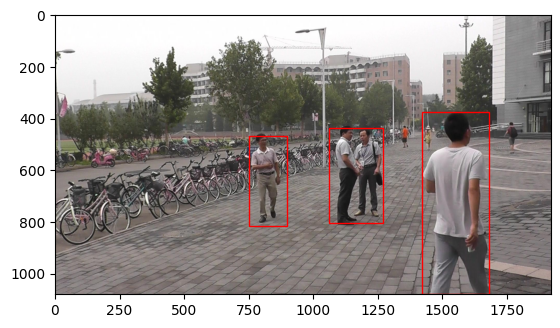

Button(description='Next frame', style=ButtonStyle())

In [4]:
data_raw = PRWRawDataset(root_path=data_args.root_path, shuffle=False, split="test")
target_shape = (144, 192)  # Resolution with which the background subtraction algorithm works
current_video_id = (0, 0)  # Static camera identifier
num_background_samples = 20
frame_id = 0


def collect_background_samples(data_raw, start_frame_id, num_background_samples=20):
    background_samples = []
    for i in range(start_frame_id, start_frame_id + num_background_samples):
        frame, _, _ = data_raw[i]
        background_samples.append(frame)
    return background_samples


def new_frame(button):
    global frame_id, current_video_id, backgorund_subtraction
    clear_output()
    if data_raw.annotations[frame_id]["video_id"] > current_video_id:
        background_samples = collect_background_samples(data_raw, frame_id, num_background_samples)
        backgorund_subtraction = BackgroundSubtractionForDetection(
            background_samples=background_samples,
            target_shape=target_shape,
        )
        frame_id += num_background_samples
        current_video_id = data_raw.annotations[frame_id]["video_id"]
    frame, _, _ = data_raw[frame_id]
    candidate_boxes = backgorund_subtraction.step(frame)
    frame_id += 1
    _, ax = plt.subplots()
    ax.imshow(frame)
    for box in candidate_boxes:
        x, y, w, h = box
        ax.add_patch(Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))
    plt.show()
    display(button)


button = widgets.Button(description="Next frame")
button.on_click(new_frame)
display(button)

### 2.2 - Person Classification Network: CustomNet
To discriminate between people and background objects, we use a family of CNN designed to be as fast as possible. Given a candidate region proposed by hte background subtraction module, the aim of the network is to output the presence of a person inside it or not. All the models are composed by sequential stacks of 3x3 2D convolution followed by Batch Norm, ReLU and max pool layers. The last activations are flattened ad processed by a linear layer with one unit output. 

With the following cell you can explore each implemented model. They have been designed so that they can process different image resolutions, specifically 128x128, 64x64 and 32x32.

In [5]:
cb = widgets.Combobox(
    placeholder="Choose CNN model",
    options=["customnet", "customnet2", "customnet3"],
    description="Model name:",
    ensure_option=True,
    disabled=False,
)


def submit(w):
    if "value" in w["new"]:
        name = str(w["new"]["value"])
        if name:
            temp_model_args = ModelArgs()
            temp_model_args.name = name
            model, train_transforms_fn, _, _ = load_model_and_transforms(model_args=temp_model_args)
            model = model.model
            display(cb, clear=True)
            display(summary(model, (1, 3) + train_transforms_fn.transforms[0].size))


cb.observe(submit)
display(cb)

Combobox(value='', description='Model name:', ensure_option=True, options=('customnet', 'customnet2', 'customn…

Layer (type:depth-idx)                   Output Shape              Param #
CustomNet3                               [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 2, 2]             --
│    └─Conv2d: 2-1                       [1, 16, 30, 30]           448
│    └─BatchNorm2d: 2-2                  [1, 16, 30, 30]           32
│    └─ReLU: 2-3                         [1, 16, 30, 30]           --
│    └─MaxPool2d: 2-4                    [1, 16, 15, 15]           --
│    └─Conv2d: 2-5                       [1, 32, 13, 13]           4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 13, 13]           64
│    └─ReLU: 2-7                         [1, 32, 13, 13]           --
│    └─MaxPool2d: 2-8                    [1, 32, 6, 6]             --
│    └─Conv2d: 2-9                       [1, 64, 4, 4]             18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 4, 4]             128
│    └─ReLU: 2-11                        [1, 64, 4, 4]             --
│    └

### 2.3 Intersection over Target Area (IoTA)
Since we are not interested to detect where exactly a person is, but rather being able to detect if a person is present or not in the scene, we also evaluate the method also by replacing the IoU function with the Intersection Over Target Area (IoTA) function, that is, the intersection between a predicted and a target box areas, divided by the area of the target box.

## 3 - Experimental Setup

### 3.1 - Dataset: Person Re-identification in the Wild (PRW)

PRW is a dataset for person re-identification, that is, identifying people in visual scenes given the image of a person as query. The dataset consists in 11816 frames with 34304 annotated boxes, with 932 different identities. Frames are captured using 6 different CCTV static cameras, allowing the use of background subtraction algorithms. Although the dataset is devised for person re-identification, its nature is suitable for our experimental setting, since it contains frames with annotated humans captured sequentially using static cameras.

From the original PRW dataset, we built two versions of it, one for training the CNN for person classification and one for object detection, resampling each original image to the YOLOv5 working resolution (640x640).

You can use the following cell to explore the raw PRW training dataset.

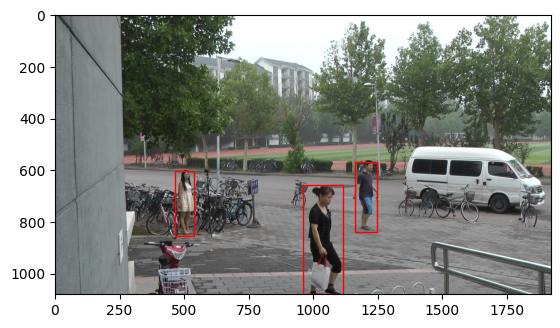

In [6]:
### An example of a PRW frame
data_raw = PRWRawDataset(root_path=data_args.root_path, shuffle=False)

idx = random.randint(0, len(data_raw) - 1)
img, boxes, video_id = data_raw[idx]

_, ax = plt.subplots()

ax.imshow(img)
for box in boxes:
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))

plt.show()

### 3.1.2 PRW for person classification: background subtraction based dataset
This section describes the strategy used to create a person classification dataset from the PRW raw dataset by running the background subtraction algorithm on it.

For each frame of the PRW raw dataset, we compute the candidate bounding boxes using the background subtraction algorithm. Each region defined by the bounding box is labeled as positive (person) if its IoTA is above or equal a threshold (0.5 in our experimental setup), otherwise it is labeled as negative.

This strategy allows to obtain a dataset belonging to the same domain of the distribution that defines the test dataset.

You can run the following cell to obtain random samples of the PRW for person classification dataset.

Notice how negative samples can still contain small or big human parts. This behavior is caused by the choice of the IoTA threshold used to generate the dataset.

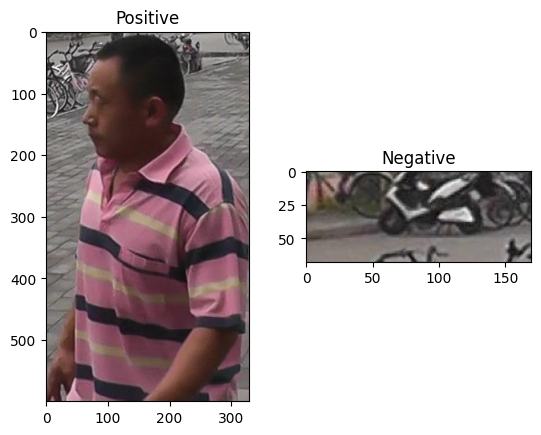

In [16]:
### An example of positive and negative samples

data_classification = PRWClassificationFromSubtraction(root_path=data_args.root_path, split="train")
pos_idx = random.randint(0, data_classification.num_positives - 1)
neg_idx = random.randint(0, data_classification.num_negatives - 1)
pos_example, _ = data_classification[pos_idx]
neg_example, _ = data_classification[data_classification.num_positives + neg_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pos_example.permute(1, 2, 0))
ax[0].set_title("Positive")
ax[1].imshow(neg_example.permute(1, 2, 0))
ax[1].set_title("Negative")
plt.show()

### 3.1.2 - PRW for person classification: anchor-based dataset
This section describes the strategy used to create a person classification dataset from the PRW raw dataset using an achor-based sampling technique. The classification dataset created using the subtraction-based strategy has some drawbacks:
- creating samples is bounded to a predefined IoU threshold;
- the dataset is unbalanced;
- the subtraction algorithm may fail to detect some ground-truths in the raw dataset;
- regions containing human parts may be mislabeled as negatives instead of positives.
The anchor-based method is a way to overcome all the above issues, under the assumption that the underlying distribution of the generated dataset will be similar to the one generated by the subtraction algorithm. 

For each frame of the original PRW dataset and for each annotated bounding box, we extract and save the region of image delimited of that box and use it as **positive** sample during the training of the classfication model. Extracting **nagative** samples is not as simple, since background objects are not annotated and the amount of space covered by background is way higher with respect to people. Also, we do not know a priori the size of the patches that we should sample from each image. 

We tried to overcome those issues by first running the background subtraction algorithm on the whole training dataset, collecting every candidate bounding box. We then filtered out every box that overlapped the most with each single person annotation, so choosing only the boxes that do not contain positives. Inspired by YOLO work, we then ran a K-Means clustering algorithm on the width and heights of the boxes to obtain K anchors. These anchors are used to define different scales on which sample negatives across each image. To summarize, we sample negatives from each image by first sampling the anchor according to its frequency probability, that is the number of boxes belonging to the anchor's cluster, and then sampling a patch from the image so that its box does not overlap with any person. We repeat the process for each image for the same number of positives in the same image, so to create a perfectly balanced dataset.

Since the nature of the dataset is non-deterministic, to properly evaluate the network performace, ww compute the metric under analysis on the dataset several times and express the network performance by means of the average and variance of the obtained results.

You can use the following cell to visualize the clustering algorithm result on the boxes extracted using the background subtraction algorithm on the training dataset.

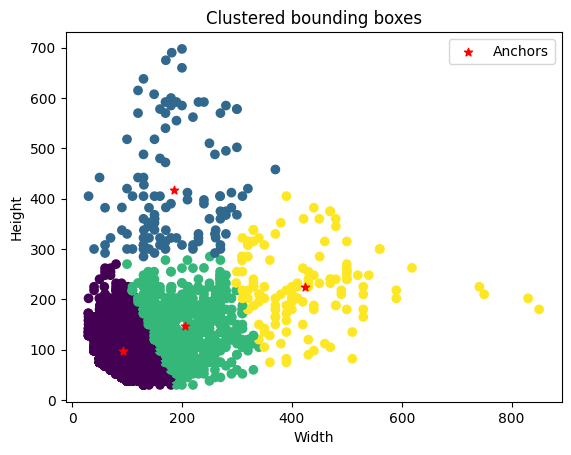

In [7]:
def get_anchors_with_weights(root_path, k=7):
    root_path = Path(root_path)
    with open(root_path / "worst_bboxes.pkl", "rb") as f:
        worst_bboxes = pkl.load(f)
    bboxes = np.array([[item[0][2], item[0][3]] for item in worst_bboxes])
    heights = np.array([item[1] for item in worst_bboxes])
    widths = np.array([item[2] for item in worst_bboxes])
    scales = np.stack([widths / np.max(widths), heights / np.max(heights)], axis=-1)  # assuming parallel maximums
    rescaled_widths_heights = bboxes / scales
    areas = rescaled_widths_heights[:, 0] * rescaled_widths_heights[:, 1]
    perc_idx = np.argmin(abs(np.sort(areas) - np.percentile(areas, 98)))
    idx = np.argsort(areas)[:perc_idx]
    rescaled_widths_heights, heights, widths, scales = rescaled_widths_heights[idx], heights[idx], widths[idx], scales[idx]
    model = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = model.fit_predict(rescaled_widths_heights)
    clusters = model.cluster_centers_
    unique_wh = np.unique(np.stack([widths, heights], axis=-1), axis=0)
    unique_scales = np.stack([unique_wh[:, 0] / np.max(unique_wh[:, 0]), unique_wh[:, 1] / np.max(unique_wh[:, 1])], axis=-1)
    anchors = {wh[0]: [anchor * scale for anchor in clusters] for scale, wh in zip(unique_scales, unique_wh)}
    anchors = {k: np.round(v).astype(np.int16) for k, v in anchors.items()}
    anchor_probs = np.bincount(labels) / len(labels)
    return anchors, anchor_probs, labels, rescaled_widths_heights, worst_bboxes


anchors, probs, labels, rescaled_widths_heights, worst_bboxes = get_anchors_with_weights(data_args.root_path, k=4)
anchors = np.array(anchors[1920])
plt.scatter(x=rescaled_widths_heights[:, 0], y=rescaled_widths_heights[:, 1], c=labels)
plt.scatter(anchors[:, 0], anchors[:, 1], marker="*", color="red", label="Anchors")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Clustered bounding boxes")
plt.legend()
plt.show()

You can run the following cell to obtain random samples of the PRW for person classification dataset.

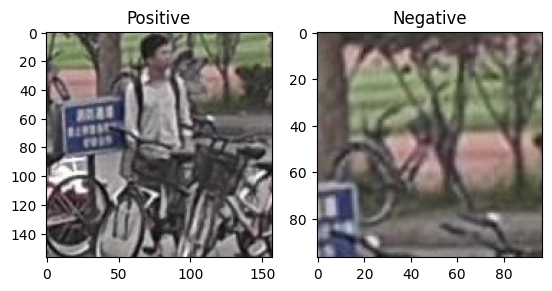

In [38]:
### An example of positive and negative samples

data_classification = PRWClassification(root_path=data_args.root_path)
pos_idx = random.randint(0, len(data_classification.positives) - 1)
neg_idx = random.randint(0, len(data_classification.negatives) - 1)
pos_example, _ = data_classification.positives[pos_idx]
neg_example, _ = data_classification.negatives[neg_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pos_example.permute(1, 2, 0))
ax[0].set_title("Positive")
ax[1].imshow(neg_example.permute(1, 2, 0))
ax[1].set_title("Negative")
plt.show()

### 3.2 - Training

This section describes the pipeline for training our person classificaition network. Since the dataset is well balanced, the model is trained to minimize the binary cross-entropy loss. We trained each model for 100 epochs with batch size 512, optimizing using Adam with 1e-2 learning rate. As a form of regularization, we applied some data augmentation strategies on the images before feeding them to the network. For each image, we sample a random portion of it and rescale it at the resolution the network expects. Then we randomly change its brightness, contrast, saturation and finally, we normalize the result.

You can launch a training for CustomNet3 on the subtraction-based classification dataset in the following cells and have a look at the results through the TensorBoard extension.

In [17]:
%load_ext tensorboard

In [18]:
### Run Tensorboard widget
%tensorboard --logdir=../notebooks/runs/

Launching TensorBoard...

In [21]:
import train

save_cfg(cfg=cfg, dirpath=".", filename="hparams.yaml")
args = CN(
    {
        "cfg_path": "hparams.yaml",
        "random_seed": 42,
        "ckpt_path": None,
    }
)
train.train(args)

Missing logger folder: runs/customnet3/
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | CustomNet3        | 24.1 K
----------------------------------------------
24.1 K    Trainable params
0         Non-trainable params
24.1 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/prahtz/workspace/lr-human-detection/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### 3.3 - Evaluation
We evaluate our classification model on the PRW for classification test set, repeating the negatives sampling multiple times and averaging. We employed some binary classification metrics to evaluate the model, such as accuracy and average precision. The results are showed in the table below, obtained after the execution of the evaluation cell.

We also evaluate the whole framework (region proposal + classification network) on the PRW test set. This time we evaluate the model by means of Average Precision over the IoU threshold range [0.5, 0.95] with step size 0.05. We also track the average time that the framework uses to make predictions.

Unlike object detection models, the background subtraction algorithm is not suitable for generating perfectly fitted bounding boxes around the proposals. Most of the proposals are rough and can include more than one ground truth boxes inside, making IoU-based detections unsuitable. For instance, if a region proposed by the background subtraction algorithm includes two ground truths, the IoU score would be extremely low for both the targets. Since we are not interested to detect where exactly a person is, but rather being able to detect if a person is present or not in the scene, we evaluated the framework also by replacing the IoU function with the Intersection Over Target Area (IoTA) function, that is, the intersection area between a predicted and a target box, divided by the area of the target box.

In [22]:
# Training configuration file path, containing model checkpoint info.
# NOTE: if you run multiple trainings, the version number MUST be incremented (e.g. version_0 -> version_1)
version_number = 0
log_path = Path(training_args.log.run_path) / f"version_{version_number}/config/test.yaml"
log_path = str(log_path)

In [23]:
from evaluate import evaluate

args = CN({"cfg_path": log_path, "random_seed": 42})  # default

evaluate(args)

/home/prahtz/workspace/lr-human-detection/env/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:164: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss_fn.pos_weight']
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            ap             │    0.9643367231369019     │
│           auroc           │    0.9112739157676697     │
│         test_loss         │    0.4295866787433624     │
└───────────────────────────┴───────────────────────────┘

In [24]:
from evaluate_with_bs import evaluate_with_bs

args = CN({"cfg_path": log_path})

evaluate_with_bs(args)

100%|██████████| 6112/6112 [01:05<00:00, 93.97it/s] 

Average Precisions: {'AP@0.5': tensor(0.9643), 'AP@0.55': tensor(0.9597), 'AP@0.6': tensor(0.9537), 'AP@0.65': tensor(0.9462), 'AP@0.7': tensor(0.9375), 'AP@0.75': tensor(0.9255), 'AP@0.8': tensor(0.9123), 'AP@0.85': tensor(0.8920), 'AP@0.8999999999999999': tensor(0.8649), 'AP@0.95': tensor(0.8265)}
Average Precisions (IoU): {'AP@0.5': tensor(0.6605), 'AP@0.55': tensor(0.6596), 'AP@0.6': tensor(0.6599), 'AP@0.65': tensor(0.6608), 'AP@0.7': tensor(0.6618), 'AP@0.75': tensor(0.6629), 'AP@0.8': tensor(0.6642), 'AP@0.85': tensor(0.6652), 'AP@0.8999999999999999': tensor(0.6659), 'AP@0.95': tensor(0.6664)}
Average backgroud subtraction time: 0.002083065586917087
Average model inference time: 0.0003038161189983426
Average total time: 0.0035874552342781757


### 3.4 - Baselines: YOLOv5

We will compare our framework with a subset of the YOLOv5 family networks. We will train YOLOv5 for person detection on the PRW dataset, using the official training recipes and hyperparameters suggested by the authors while experimenting just with the number of layer to freeze during SGD. We will use the nano version of the architecture (YOLOv5n), since we are interested on the fastest option to compare our framework with. Furthemore, we will show the results of two smaller variants of YOLOv5n (YOLOv5p and YOLOv5f) that are obtained by scaling down YOLOv5n width-wise by a factor of 2 and 4 respectively.

We found that training the networks without freezing layers resulted in better AP scores in the test set, for every architecture variant. In this notebook, an example of how to train and evaluate YOLOv5n will be showed. 

In [5]:
del sys.modules["models"]  # Module names conflict workaround
import yolov5.train
from yolov5.models.yolo import DetectionModel

In [ ]:
cb = widgets.Combobox(
    placeholder="Choose CNN model",
    options=["yolov5n", "yolov5p", "yolov5f"],
    description="Model name:",
    ensure_option=True,
    disabled=False,
)


def submit(w):
    if "value" in w["new"]:
        name = str(w["new"]["value"])
        if name:
            display(cb, clear=True)
            display(DetectionModel(cfg=f"../src/config/{name}.yaml", nc=1))


cb.observe(submit)
display(cb)

Combobox(value='yolov5f', description='Model name:', ensure_option=True, options=('yolov5n', 'yolov5p', 'yolov…

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolov5.models.common.Conv               [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolov5.models.common.Conv               [16, 32, 3, 2]                
  2                -1  1      4800  yolov5.models.common.C3                 [32, 32, 1]                   
  3                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
  4                -1  2     29184  yolov5.models.common.C3                 [64, 64, 2]                   
  5                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  6                -1  3    156928  yolov5.models.common.C3                 [128, 128, 3]                 
  7                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]             

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [8]:
data_yolo_cfg = {
    # Dataset paths
    "path": str((Path(data_args.root_path) / "detection").absolute()),
    "train": "images/train",
    "val": "images/valid",
    "test": "images/test",
    # Number of classes
    "nc": 1,
    # Class names
    "names": ["person"],
}
yolo_cfg_path = "../src/config/yolov5n.yaml"
save_cfg(cfg=CN(data_yolo_cfg), dirpath=".", filename="prw_yolov5.yaml")
yolov5.train.run(weights="", cfg=yolo_cfg_path, data="prw_yolov5.yaml", freeze=0, project="../notebooks/runs/yolov5n")

train: weights=, cfg=../src/config/yolov5n.yaml, data=prw_yolov5.yaml, hyp=../env/lib/python3.10/site-packages/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/yolov5n, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, seed=0, local_rank=-1, entity=None, bbox_interval=-1, artifact_alias=latest, neptune_token=None, neptune_project=None, s3_upload_dir=None, upload_dataset=False, hf_model_id=None, hf_token=None, hf_private=False, hf_dataset_id=None, roboflow_token=None, roboflow_upload=False, pretrained=False
YOLOv5 🚀 2023-9-12 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2060, 5932MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight

  0                -1  1      1760  yolov5.models.common.Conv               [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolov5.models.common.Conv               [16, 32, 3, 2]                
  2                -1  1      4800  yolov5.models.common.C3                 [32, 32, 1]                   
  3                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
  4                -1  2     29184  yolov5.models.common.C3                 [64, 64, 2]                   
  5                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  6                -1  3    156928  yolov5.models.common.C3                 [128, 128, 3]                 
  7                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  8                -1  1    296448  yolov5.models.common.C3                 [256, 256, 1]                 
  9                -1  1    164608  y

requirements: /home/prahtz/workspace/lr-human-detection-dev/env/lib/python3.10/site-packages/requirements.txt not found, check failed.


YOLOv5n summary: 214 layers, 1765270 parameters, 1765270 gradients, 4.2 GFLOPs

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 60 weight(decay=0.0005), 60 bias
train: Scanning /home/prahtz/workspace/lr-human-detection-dev/data/PRW/detection/labels/train.cache... 4563 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4563/4563 [00:00<?, ?it/s]
train: WARNING ⚠️ /home/prahtz/workspace/lr-human-detection-dev/data/PRW/detection/images/train/c6s1_000476.jpg: 1 duplicate labels removed
val: Scanning /home/prahtz/workspace/lr-human-detection-dev/data/PRW/detection/labels/valid.cache... 1141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1141/1141 [00:00<?, ?it/s]

AutoAnchor: 3.80 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to runs/yolov5n/exp/labels.jpg... 
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
i

Namespace(weights='', cfg='../src/config/yolov5n.yaml', data='prw_yolov5.yaml', hyp={'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket='', cache=None, image_weights=False, device='', multi_scale=False, single_cls=False, optimizer='SGD', sync_bn=False, workers=8, project='runs/yolov5n', name='exp', exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, seed=0, local_rank=-1, entity=None, bbox_int

In [7]:
# Evaluation

from evaluate_yolo import evaluate_yolo

exp_number = ""
args = CN({"model_source": f"../notebooks/runs/yolov5n/exp{exp_number}/weights/best.pt", "data_path": data_args.root_path})
evaluate_yolo(args)

100%|██████████| 6112/6112 [08:42<00:00, 11.71it/s]


Average Precisions: {'AP@0.5': tensor(0.95242), 'AP@0.55': tensor(0.93554), 'AP@0.6': tensor(0.89843), 'AP@0.65': tensor(0.82220), 'AP@0.7': tensor(0.72568), 'AP@0.75': tensor(0.62710), 'AP@0.8': tensor(0.55527), 'AP@0.85': tensor(0.51204), 'AP@0.8999999999999999': tensor(0.49470), 'AP@0.95': tensor(0.49536)}
Average Precisions (IoU): {'AP@0.5': tensor(0.94483), 'AP@0.55': tensor(0.91961), 'AP@0.6': tensor(0.86510), 'AP@0.65': tensor(0.76965), 'AP@0.7': tensor(0.66344), 'AP@0.75': tensor(0.57653), 'AP@0.8': tensor(0.52410), 'AP@0.85': tensor(0.50021), 'AP@0.8999999999999999': tensor(0.49863), 'AP@0.95': tensor(0.50260)}
Average time for each image: 0.06317767418960002


## 4 - Results

We are now going to show the results obtained by the experimental setup described in the previous section. All the evaluations have been performed and recorded on a Intel(R) i7-1065G7 CPU.

Table 1: Classification models comparison.
| **_CPU: Intel(R) Core(TM)<br>i7-1065G7 CPU @ 1.30GHz_** | **CustomNet1<br>(128x128)** | **CustomNet2<br>(64x64)** | **CustomNet3<br>(32x32)** |
|---------------------------------------------------------|-----------------------------|---------------------------|---------------------------|
| **Average Precision (%)**                               |            98.21            |           97.77           |           96.43           |
| **Average Prediction Time (s)**                         |         4.886029e-3         |        1.689482e-3        |        3.038161e-4        |

Table 2: Performance comparison between the proposed method and the YOLOv5 baselines.
|                 | **BS + CustomNet3 <br>(subtraction dataset)** | **BS + CustomNet3 <br>(anchor-based dataset)** | **YOLOV5n** | **YOLOV5p** | **YOLOV5f** |
|-----------------|-----------------------------------------------|------------------------------------------------|-------------|-------------|-------------|
| **IoTA AP@0.5** |                     0.9643                    |                     0.9455                     |   0.95242   |   0.94203   |   0.92026   |
| **IoTA AP@0.6** |                     0.9537                    |                     0.9283                     |   0.89843   |   0.88136   |   0.82060   |
| **IoTA AP@0.7** |                     0.9375                    |                     0.9024                     |   0.72568   |   0.69726   |   0.63499   |
|                 |                                               |                                                |             |             |             |
| **IoU AP@0.5**  |                     0.6618                    |                     0.6554                     |   0.94483   |   0.93094   |   0.90118   |
| **IoU AP@0.6**  |                     0.6605                    |                     0.6503                     |   0.86510   |   0.83924   |   0.76938   |
| **IoU AP@0.7**  |                     0.6599                    |                     0.6499                     |   0.66344   |   0.62749   |   0.58068   |

Table 3: Speed comparison between the proposed method and the YOLOv5 baselines.
| **_CPU: Intel(R) Core(TM) <br>i7-1065G7 CPU @ 1.30GHz_** | **BS + <br>CustomNet3** | **YOLOv5n** | **YOLOv5p** | **YOLOv5f** |
|----------------------------------------------------------|-------------------------|-------------|-------------|-------------|
| **Average Absolute Prediction Time (s)**                 | 6.627545e-3             | 6.317767e-2 | 4.285647e-2 | 3.497190e-2 |
| **Speedup of BS + CustomNet3 (%)**                       | 100                     | 953.25      | 646.64      | 527.67      |

### 4.1 - Discussion
Table 1 shows a comparison among CustomNet models. As expected, the more the network is small, the faster it is, surprisingly keeping almost the same effectiveness, by means of accuracy and average precision. Given the findings, from now on, we will show only results with CustomNet3.

Table 2 shows how the models performed by means of average precision on the PRW test set. When using the IoTA function, the proposed method achieves better performance w.r.t. YOLOv5 baselines. As expected, removing the penalization of predictions that incorporate multiple ground truths helps our method to report high AP values, even at different thresholds. When using the IoU function, we observe big degradation of AP scores for our method, even if they remain almost constant when the threshold changes. As expected, YOLOv5 models scores remained almost the same, since those model are trained to regress the ground truth bounding boxes IoU directly.

Table 3 shows the speed of the proposed method in absolute terms and w.r.t. the baselines. On our CPU, our method resulted the fastest, around 9 times quicker than the fastest publicly available architecture, YOLOv5n, and around 5 times faster than the smallest downscaled YOLOv5 baseline, YOLOv5f.

Overall, the proposed method performed better and faster w.r.t. every baseline when evaluated using the IoTA function. Otherwise, when evaluating with the IoU function, the baselines are way more effective and precise, as expected. This suggests that our method must be employed in enviroments where the precision of the regions proposed by the background subtraction algorithm does not matter, and for tasks where what matters the most is to discriminate from the background moving objects on the scene, independently of its position. An example of such task is intrusion detection, where the position of the moving object in the scene is not important.


# 5 - Background subtraction optimization

Most of the computation time of our hybrid framework is on the background subtraction step, because the algorithm is written in Python and it is unoptimized. The most unefficient parts of the implementation are the binary mask computation and the background image update. We used Cython to rewrite the code of those parts and compute the speed-up, to see if there are any improvements.

We ran the background subtraction algorithm on the same whole PRW test set while monitoring the algorithm speed. The unoptimized algorithm took on average 54ms to process a frame, while the optimized version 26ms, a speed-up of ~208%.
It would be interesting to further optimize the algorithm by writing it entirely in C/C++ and observe the achieved speed-up. 